# Pauli Propagation of Parametrized Circuits: Tutorial

* **Step 0:** Import the necessary libraries

In [1]:
import pennylane as qml # To define the circuit
from pprop.propagator import Propagator # For Pauli Propagation

* **Step 1:** Define the Ansatz as a function of a parameter list that returns the `qml.expval` of the desired observables

In [2]:
# Function of parameters
def ansatz(params : list[float]):
    qml.RX(params[0], wires=0)
    qml.RX(params[1], wires=1)

    qml.RY(params[2], wires=0)
    qml.RY(params[3], wires=1)
    
    qml.Hadamard(wires = 2)
    
    qml.Barrier()
    
    qml.CNOT(wires = [0, 1])
    qml.CNOT(wires = [1, 2])
    
    qml.Barrier()
    
    qml.RY(params[4], wires=0)
    qml.RY(params[5], wires=1)
    qml.RY(params[6], wires=2)
    
    return [qml.expval(qml.PauliZ(qubit)) for qubit in range(3)] + [qml.expval(qml.PauliX(0)@qml.PauliX(1)@qml.PauliX(2))] + [qml.expval(qml.PauliY(2))]

* **Step 2:** Define the propagator, use `.propagate()` to propagate and use `.lambdify()` to convert the circuit as a function of the parameters

In [3]:
prop = Propagator(
    ansatz, 
    k1 = None, # Cutoff on the Pauli Weight
    k2 = None, # Cutoff on the frequencies
)
prop

Propagator
  Number of qubits : 3
  Trainable parameters : 7
  Cutoff 1: None | Cutoff 2: None
  Observables [Z(0), Z(1), Z(2), (X(0) @ X(1) @ X(2)), Y(2)]
0: ──RX──RY──||─╭●─────||──RY─┤  <Z> ╭<X@X@X>     
1: ──RX──RY──||─╰X─╭●──||──RY─┤  <Z> ├<X@X@X>     
2: ──H───────||────╰X──||──RY─┤  <Z> ╰<X@X@X>  <Y>

In [4]:
prop.propagate()

Propagating Y(2): 100%|██████████| 5/5 [00:00<00:00, 1220.55it/s]      


In [5]:
func = prop.lambdify()

In [6]:
random_params = qml.numpy.random.rand(prop.num_params)
prop_output = func(random_params)
print(prop_output)

[tensor(0.89489407, requires_grad=True), tensor(0.49815245, requires_grad=True), tensor(-0.746534, requires_grad=True), tensor(0.13089247, requires_grad=True), 0]


The output *should* be equal to the `qml.QNode` execution:

In [7]:
device = qml.device('default.qubit', wires = 4)

circuit = qml.QNode(ansatz, device)
pennylane_output = circuit(random_params)
pennylane_output

[tensor(0.89489407, requires_grad=True),
 tensor(0.49815245, requires_grad=True),
 tensor(-0.746534, requires_grad=True),
 tensor(0.13089247, requires_grad=True),
 tensor(-5.55111512e-17, requires_grad=True)]

How much is the difference between the two outputs?

In [8]:
for out1, out2 in zip(prop_output, pennylane_output):
    print(abs(out1 - out2))

3.3306690738754696e-16
2.7755575615628914e-16
3.3306690738754696e-16
1.1102230246251565e-16
5.551115123125783e-17


You can inspect the functions through `.propagate()`:

In [10]:
prop.expression()

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

['Z0 = -sin(\\theta_{2})*sin(\\theta_{3})*sin(\\theta_{4})*cos(\\theta_{0})*cos(\\theta_{1}) + cos(\\theta_{0})*cos(\\theta_{2})*cos(\\theta_{4})',
 'Z1 = -sin(\\theta_{3})*sin(\\theta_{5})*cos(\\theta_{1}) + cos(\\theta_{0})*cos(\\theta_{1})*cos(\\theta_{2})*cos(\\theta_{3})*cos(\\theta_{5})',
 'Z2 = -sin(\\theta_{6})',
 'X0@X1@X2 = -sin(\\theta_{0})*sin(\\theta_{1})*sin(\\theta_{5})*cos(\\theta_{4})*cos(\\theta_{6}) + sin(\\theta_{2})*cos(\\theta_{0})*cos(\\theta_{4})*cos(\\theta_{5})*cos(\\theta_{6}) + sin(\\theta_{3})*sin(\\theta_{4})*cos(\\theta_{0})*cos(\\theta_{1})*cos(\\theta_{2})*cos(\\theta_{5})*cos(\\theta_{6}) + sin(\\theta_{4})*sin(\\theta_{5})*cos(\\theta_{1})*cos(\\theta_{3})*cos(\\theta_{6})',
 'Y2 = 0']

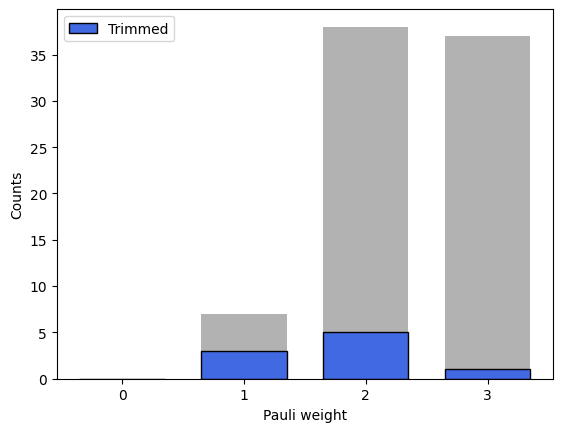

In [11]:
from pprop.plot.obs import plot_obs
plot_obs(prop)


> **Note:** Check out the other notebooks for additional examples and use cases.